<center><h1>DSCI 552: Machine Learning for Data Science</h1></center><br>
<center>Time Series Classification</center>

<h3>Homework 4</h3>
<p></p>
<b><span>Name: Sri Manvith Vaddeboyina</span></b><br>
<b><span>USC ID: 1231409457</span></b><br>
<b><span>Github username: srimanvithv</span></b>

## 1. Time Series Classification Part 1: Feature Creation/Extraction

### (a) Download Data

Package imports

In [1]:
import os
import re
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import bootstrap
from sklearn.utils import resample
import statsmodels.formula.api as smf
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import RFECV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, roc_curve, auc
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

Get the AReM Data Set

Download the AReM data from:<br>
https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+system+based+on+Multisensor+data+fusion+\%28AReM\%29 <br><br>
The dataset contains 7 folders that represent seven types of activities. In
each folder, there are multiple files each of which represents an instant of a human
performing an activity. Each file containis 6 time series collected from activities of the same person, which are called avg_rss12, var_rss12, avg_rss13, var_rss13, vg_rss23, and ar_rss23. There are 88 instances in the dataset, each of which contains 6 time series and each time series has 480 consecutive values.

In [2]:
def load_and_preprocess_csv(file_path):
    if file_path == '../data/AReM/bending2/dataset4.csv':
        df = pd.read_csv(file_path, skiprows = 5,usecols = [1, 2, 3, 4, 5, 6],names=['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'], delim_whitespace = True) 

    else:
        df = pd.read_csv(file_path, skiprows = 4, usecols = [1, 2, 3, 4, 5, 6])

    return df

def load_files_in_directory(directory_path):
    files = {}
    for root, dirs, filenames in os.walk(directory_path):
        for filename in filenames:
            if filename.endswith('.csv'):
                file_path = os.path.join(root, filename)
                df = load_and_preprocess_csv(file_path)
                if df is not None:
                    df['label'] = file_path.split("/")[3]
                    files[file_path] = df
    return files

data_folder_path = '../data/AReM/'
files = load_files_in_directory(data_folder_path)

### (b) Test and Train Data

In [3]:
root = "../data/AReM"

train_files, test_files = [], []

train_dfs, test_dfs = {}, {}

files_ = [os.path.join(root_path, file_name) 
         for root_path, _, files in os.walk(root) 
         for file_name in files 
         if not file_name.endswith('.pdf')]

for i in files_:
    if 'bending1' in i or 'bending2' in i:
        if 'dataset1.csv' in i or 'dataset2.csv' in i:
            test_files.append(i)
        else:
            train_files.append(i)
    else:
        if 'dataset1.csv' in i or 'dataset2.csv' in i or 'dataset3.csv' in i:
            test_files.append(i)
        else:
            train_files.append(i)

for file_path in train_files:
    if file_path == '../data/AReM/bending2/dataset4.csv':
        df = pd.read_csv(file_path, skiprows = 5,usecols = [1, 2, 3, 4, 5, 6],names=['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'], delim_whitespace = True) 
    else:
        df = pd.read_csv(file_path, skiprows = 4, usecols = [1, 2, 3, 4, 5, 6])
    
    df['label'] = file_path.split("/")[3]
    train_dfs[file_path] = df

for file_path in test_files:
    if file_path == '../data/AReM/bending2/dataset4.csv':
        df = pd.read_csv(file_path, skiprows = 5,usecols = [1, 2, 3, 4, 5, 6],names=['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'], delim_whitespace = True) 
    else:
        df = pd.read_csv(file_path, skiprows = 4, usecols = [1, 2, 3, 4, 5, 6])  
    
    df['label'] = file_path.split("/")[3]
    test_dfs[file_path] = df
    
print('\033[1mTraining set size: ',len(train_files))
print('\033[1mTesting set size: ',len(test_files))

Training set size:  69
Testing set size:  19


### (c) Feature Extraction

#### i. Research

The time-domain features that are usually used in time series classification are: 
- <b>Mean</b>
- <b>Median</b>
- <b>Minimum</b>
- <b>Maximum</b>
- <b>Standard Deviation</b>
- <b>Variance</b>
- <b>Skewness</b>
- <b>Kurtosis</b>
- <b>Quantiles</b>
- <b>Range</b>
- <b>Interquartile Range (IQR)</b>

#### ii. Extraction

In [4]:
def extract(files_list):
    features = ['min', 'max', 'mean', '50%', 'std', '25%', '75%']

    time_series_statistical_features = ['min', 'max', 'mean', 'median', 'standard deviation', '1st quart', '3rd quart']

    data_list = []
    instance_column = list(range(1, len(files_list) + 1))
    
    labels = []
    for file_df in files_list.values():
        labels.append(file_df['label'][0])
        statistics = file_df.drop('label', axis=1).describe()
        feature_data = [statistics[feature][param] for feature in file_df.columns if feature != 'label' for param in features]
        data_list.append([len(data_list) + 1] + feature_data)
    
    columns = ['Instance'] + [f"{param}_{i+1}" for i in range(len(file_df.columns) - 1) for param in time_series_statistical_features]
    dataset = pd.DataFrame(data_list, columns=columns)
    dataset['Instance'] = instance_column
    dataset['label'] = labels
    return dataset

In [5]:
print("\033[1mComplete Dataset:")
complete_dataset_summary_label = extract(files)
complete_dataset_summary = extract(files).iloc[:,:-1]
display(complete_dataset_summary)

Complete Dataset:


,Instance,min_1,max_1,mean_1,median_1,standard deviation_1,1st quart_1,3rd quart_1,min_2,max_2,...,standard deviation_5,1st quart_5,3rd quart_5,min_6,max_6,mean_6,median_6,standard deviation_6,1st quart_6,3rd quart_6
0,1,36.25,48.00,43.969125,44.50,1.618364,43.3100,44.67,0.0,1.50,...,3.318301,20.5000,23.7500,0.0,2.96,0.555313,0.490,0.487826,0.0000,0.8300
1,2,37.00,48.00,43.454958,43.25,1.386098,42.5000,45.00,0.0,1.58,...,2.488862,22.2500,24.0000,0.0,5.26,0.679646,0.500,0.622534,0.4300,0.8700
2,3,33.00,47.75,42.179813,43.50,3.670666,39.1500,45.00,0.0,3.00,...,3.849448,30.4575,36.3300,0.0,2.18,0.613521,0.500,0.524317,0.0000,1.0000
3,4,33.00,45.75,41.678063,41.75,2.243490,41.3300,42.75,0.0,2.83,...,2.411026,28.4575,31.2500,0.0,1.79,0.383292,0.430,0.389164,0.0000,0.5000
4,5,37.25,45.00,40.624792,40.50,1.476967,39.2500,42.00,0.0,1.30,...,2.188449,33.0000,36.0000,0.0,1.92,0.570583,0.430,0.582915,0.0000,1.3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,84,18.50,44.25,35.752354,36.00,4.614802,33.0000,39.33,0.0,12.60,...,3.120057,14.0000,18.0625,0.0,9.39,3.069667,2.770,1.748326,1.7975,4.0600
84,85,24.25,45.00,37.177042,36.25,3.581301,34.5000,40.25,0.0,8.58,...,2.890347,17.9500,21.7500,0.0,9.34,2.921729,2.500,1.852600,1.5000,3.9000
85,86,23.33,43.50,36.244083,36.75,3.822016,33.4575,39.25,0.0,9.71,...,3.617702,15.7500,21.0000,0.0,11.15,3.530500,3.110,1.963685,2.1700,4.6175
86,87,26.25,44.25,36.957458,36.29,3.434863,34.5000,40.25,0.0,8.64,...,2.851673,14.0000,18.2500,0.0,8.34,2.934625,2.525,1.631380,1.6600,4.0300


In [6]:
print("\033[1mTrain Dataset:")
train_dataset_summary_label = extract(train_dfs)
train_dataset_summary = extract(train_dfs).iloc[:,:-1]
display(train_dataset_summary)

Train Dataset:


,Instance,min_1,max_1,mean_1,median_1,standard deviation_1,1st quart_1,3rd quart_1,min_2,max_2,...,standard deviation_5,1st quart_5,3rd quart_5,min_6,max_6,mean_6,median_6,standard deviation_6,1st quart_6,3rd quart_6
0,1,36.25,48.00,43.969125,44.50,1.618364,43.3100,44.67,0.0,1.50,...,3.318301,20.5000,23.7500,0.0,2.96,0.555313,0.490,0.487826,0.0000,0.8300
1,2,37.00,48.00,43.454958,43.25,1.386098,42.5000,45.00,0.0,1.58,...,2.488862,22.2500,24.0000,0.0,5.26,0.679646,0.500,0.622534,0.4300,0.8700
2,3,33.00,47.75,42.179813,43.50,3.670666,39.1500,45.00,0.0,3.00,...,3.849448,30.4575,36.3300,0.0,2.18,0.613521,0.500,0.524317,0.0000,1.0000
3,4,33.00,45.75,41.678063,41.75,2.243490,41.3300,42.75,0.0,2.83,...,2.411026,28.4575,31.2500,0.0,1.79,0.383292,0.430,0.389164,0.0000,0.5000
4,5,35.00,47.40,43.954500,44.33,1.558835,43.0000,45.00,0.0,1.70,...,1.999604,35.3625,36.5000,0.0,1.79,0.493292,0.430,0.513506,0.0000,0.9400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,65,18.50,44.25,35.752354,36.00,4.614802,33.0000,39.33,0.0,12.60,...,3.120057,14.0000,18.0625,0.0,9.39,3.069667,2.770,1.748326,1.7975,4.0600
65,66,24.25,45.00,37.177042,36.25,3.581301,34.5000,40.25,0.0,8.58,...,2.890347,17.9500,21.7500,0.0,9.34,2.921729,2.500,1.852600,1.5000,3.9000
66,67,23.33,43.50,36.244083,36.75,3.822016,33.4575,39.25,0.0,9.71,...,3.617702,15.7500,21.0000,0.0,11.15,3.530500,3.110,1.963685,2.1700,4.6175
67,68,26.25,44.25,36.957458,36.29,3.434863,34.5000,40.25,0.0,8.64,...,2.851673,14.0000,18.2500,0.0,8.34,2.934625,2.525,1.631380,1.6600,4.0300


In [7]:
print("\033[1mTest Dataset:")
test_dataset_summary_label = extract(test_dfs)
test_dataset_summary = extract(test_dfs).iloc[:,:-1]
display(test_dataset_summary)

Test Dataset:


,Instance,min_1,max_1,mean_1,median_1,standard deviation_1,1st quart_1,3rd quart_1,min_2,max_2,...,standard deviation_5,1st quart_5,3rd quart_5,min_6,max_6,mean_6,median_6,standard deviation_6,1st quart_6,3rd quart_6
0,1,37.25,45.00,40.624792,40.500,1.476967,39.2500,42.0000,0.0,1.30,...,2.188449,33.0000,36.0000,0.0,1.92,0.570583,0.430,0.582915,0.0000,1.300
1,2,38.00,45.67,42.812812,42.500,1.435550,42.0000,43.6700,0.0,1.22,...,1.995255,32.0000,34.5000,0.0,3.11,0.571083,0.430,0.601010,0.0000,1.300
2,3,19.33,43.50,34.227771,35.500,4.889576,30.5000,37.7500,0.0,14.50,...,3.092094,14.7500,18.6700,0.0,9.74,3.394125,3.100,1.792090,2.1050,4.425
3,4,12.50,45.00,33.509729,34.125,4.850923,30.5000,36.7500,0.0,13.05,...,3.133564,14.6275,18.7500,0.0,8.96,3.378479,3.085,1.787360,2.0600,4.440
4,5,15.00,46.75,34.660583,35.000,5.315110,31.0000,38.2500,0.0,13.44,...,3.155015,14.2500,18.5000,0.0,8.99,3.244396,3.000,1.630983,2.1200,4.240
5,6,12.75,51.00,24.562958,24.250,3.737514,23.1875,26.5000,0.0,6.87,...,3.693786,20.5000,27.0000,0.0,4.97,0.700188,0.500,0.693720,0.4300,0.870
6,7,0.00,42.75,27.464604,28.000,3.583582,25.5000,30.0000,0.0,7.76,...,5.053642,15.0000,20.7500,0.0,6.76,1.122125,0.830,1.012342,0.4700,1.300
7,8,33.33,48.00,44.334729,45.000,2.476940,42.2500,46.5000,0.0,3.90,...,5.401794,9.3300,17.7500,0.0,5.02,0.933000,0.830,0.673609,0.4700,1.250
8,9,35.50,46.25,43.174938,43.670,1.989052,42.5000,44.5000,0.0,2.12,...,2.983976,12.7500,16.5000,0.0,5.72,0.911979,0.830,0.666161,0.4700,1.220
9,10,32.75,47.00,42.760563,44.500,3.398919,41.3300,45.3725,0.0,3.34,...,4.296574,13.0000,18.5650,0.0,5.73,0.842271,0.710,0.722165,0.4300,1.090


#### iii. Standard Deviation

In [8]:
std_complete_dataset = pd.DataFrame({'Feature': complete_dataset_summary.drop(columns=['Instance']).std().index, 'Standard Deviation': complete_dataset_summary.drop(columns=['Instance']).std().values})
print("\033[1mComplete Dataset:")
std_complete_dataset

Complete Dataset:


,Feature,Standard Deviation
0,min_1,9.569975
1,max_1,4.394362
2,mean_1,5.335718
3,median_1,5.440054
4,standard deviation_1,1.772153
5,1st quart_1,6.153590
6,3rd quart_1,5.138925
7,min_2,0.000000
8,max_2,5.062729
9,mean_2,1.574164


In [9]:
std_train_dataset = pd.DataFrame({'Feature': train_dataset_summary.drop(columns=['Instance']).std().index, 'Standard Deviation': train_dataset_summary.drop(columns=['Instance']).std().values})
print("\033[1mTrain Dataset:")
std_train_dataset

Train Dataset:


,Feature,Standard Deviation
0,min_1,8.794295
1,max_1,4.429182
2,mean_1,4.917717
3,median_1,4.956111
4,standard deviation_1,1.758629
5,1st quart_1,5.731262
6,3rd quart_1,4.783645
7,min_2,0.000000
8,max_2,5.147841
9,mean_2,1.600661


In [10]:
std_test_dataset = pd.DataFrame({'Feature': test_dataset_summary.drop(columns=['Instance']).std().index, 'Standard Deviation': test_dataset_summary.drop(columns=['Instance']).std().values})
print("\033[1mTest Dataset:")
std_test_dataset

Test Dataset:


,Feature,Standard Deviation
0,min_1,12.136206
1,max_1,4.379342
2,mean_1,6.790086
3,median_1,7.088085
4,standard deviation_1,1.869285
5,1st quart_1,7.673052
6,3rd quart_1,6.385720
7,min_2,0.000000
8,max_2,4.870395
9,mean_2,1.500529


In [11]:
confidence_interval = [
    [col, complete_dataset_summary[col].std(), bootstrap((complete_dataset_summary[col],), np.std, confidence_level=0.9, random_state=1, method='percentile').confidence_interval.low, bootstrap((complete_dataset_summary[col],), np.std, confidence_level=0.9, random_state=1, method='percentile').confidence_interval.high]
    for col in complete_dataset_summary.columns]

bootstrap_complete_dataset_summary = pd.DataFrame(confidence_interval, columns=['Feature Name', 'Standard Deviation', 'Lower Bound', 'Upper Bound'])[1:]
print("\033[1mComplete Dataset:")
bootstrap_complete_dataset_summary

Complete Dataset:


,Feature Name,Standard Deviation,Lower Bound,Upper Bound
1,min_1,9.569975,8.217348,10.704231
2,max_1,4.394362,3.306005,5.269063
3,mean_1,5.335718,4.675214,5.837115
4,median_1,5.440054,4.760294,5.964649
5,standard deviation_1,1.772153,1.562763,1.935570
6,1st quart_1,6.153590,5.542312,6.603819
7,3rd quart_1,5.138925,4.308947,5.806972
8,min_2,0.000000,0.000000,0.000000
9,max_2,5.062729,4.595134,5.377385
10,mean_2,1.574164,1.393100,1.698068


In [12]:
confidence_interval = [
    [col, train_dataset_summary[col].std(), bootstrap((train_dataset_summary[col],), np.std, confidence_level=0.9, random_state=1, method='percentile').confidence_interval.low, bootstrap((train_dataset_summary[col],), np.std, confidence_level=0.9, random_state=1, method='percentile').confidence_interval.high]
    for col in train_dataset_summary.columns]

bootstrap_train_dataset_summary = pd.DataFrame(confidence_interval, columns=['Feature Name', 'Standard Deviation', 'Lower Bound', 'Upper Bound'])[1:]
print("\033[1mTrain Dataset:")
bootstrap_train_dataset_summary

Train Dataset:


,Feature Name,Standard Deviation,Lower Bound,Upper Bound
1,min_1,8.794295,7.471305,9.958659
2,max_1,4.429182,3.257759,5.343441
3,mean_1,4.917717,4.284080,5.385967
4,median_1,4.956111,4.297972,5.443220
5,standard deviation_1,1.758629,1.531020,1.932402
6,1st quart_1,5.731262,5.108366,6.174618
7,3rd quart_1,4.783645,3.878226,5.492035
8,min_2,0.000000,0.000000,0.000000
9,max_2,5.147841,4.618632,5.484835
10,mean_2,1.600661,1.391740,1.726822


In [13]:
confidence_interval = [
    [col, test_dataset_summary[col].std(), bootstrap((test_dataset_summary[col],), np.std, confidence_level=0.9, random_state=1, method='percentile').confidence_interval.low, bootstrap((test_dataset_summary[col],), np.std, confidence_level=0.9, random_state=1, method='percentile').confidence_interval.high]
    for col in test_dataset_summary.columns]

bootstrap_test_dataset_summary = pd.DataFrame(confidence_interval, columns=['Feature Name', 'Standard Deviation', 'Lower Bound', 'Upper Bound'])[1:]
print("\033[1mTest Dataset:")
bootstrap_test_dataset_summary

Test Dataset:


,Feature Name,Standard Deviation,Lower Bound,Upper Bound
1,min_1,12.136206,8.457455,14.310378
2,max_1,4.379342,1.762636,6.264174
3,mean_1,6.790086,4.752908,7.786925
4,median_1,7.088085,5.060133,8.106922
5,standard deviation_1,1.869285,1.266126,2.234854
6,1st quart_1,7.673052,5.820522,8.566772
7,3rd quart_1,6.385720,4.202041,7.486927
8,min_2,0.000000,0.000000,0.000000
9,max_2,4.870395,3.590871,5.396045
10,mean_2,1.500529,0.972045,1.740835


#### iv. Select Features

1. **Max (Maximum Value):**
   - **Reason:** Max captures extreme values, highlighting distinct motion characteristics. Useful for identifying unique traits in bending vs. non-bending.

2. **Mean (Average Value):**
   - **Reason:** Mean provides a central tendency measure, representing typical behavior. Robust against outliers and helpful for understanding overall motion patterns.

3. **75th Percentile (Third Quartile):**
   - **Reason:** The 75th percentile considers the upper data range, revealing relatively high values without extreme outliers. This feature aids in distinguishing bending from non-bending activities by focusing on significant upper quartile differences.

# 

## 2. ISLR 3.7.4

I collect a set of data (n = 100 observations) containing a single predictor and a quantitative response. I then fit a linear regression model to the data, as well as a separate cubic regression, i.e. <br>
<center>Y = β<sub>0</sub> + β<sub>1</sub>X + β<sub>2</sub>$X^2$ + β<sub>3</sub>$X^3$ + ε<center>

### (a) Linear Train

<b>(a) Suppose that the true relationship between X and Y is linear, i.e. Y = β0 + β1X + ε. Consider the training residual sum of squares (RSS) for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.</b>

<b>Answer:</b> In this scenario, the expectation is that the training RSS of the cubic regression model would be lower than that of the linear regression model. This expectation is based on the notion that more predictors in cubic regression can result in a better fit to the training data. However, this doesn't necessarily imply that cubic regression is a better model, as it may overfit the data due to its excessive complexity for a linear relationship. The lower training RSS in cubic regression is primarily due to its increased flexibility in capturing complex relationships.

### (b) Linear Test

<b>(b) Answer (a) using test rather than training RSS.<b>

<b>Answer:</b> In scenarios with more predictors and higher-order terms, cubic regression tends to overfit due to increased variance without a corresponding reduction in bias when the true underlying model is linear. Consequently, for test data, linear regression is expected to have a lower Residual Sum of Squares (RSS) compared to cubic regression, as it is more likely to provide relatively accurate regression results and mitigate the issues associated with overfitting.

### (c) Not Linear Train

<b>(c) Suppose that the true relationship between X and Y is not linear, but we don’t know how far it is from linear. Consider the training RSS for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.</b>

<b>Answer:</b> Even in cases where the true underlying relationship between variables is unknown, cubic regression often offers superior flexibility when more predictors are involved. This increased flexibility allows cubic regression to capture complex patterns and variations in the data more effectively than linear regression. Consequently, during training, cubic regression tends to produce a lower Residual Sum of Squares (RSS) compared to linear regression. This is because higher model flexibility generally leads to a better fit to the training data, even when the true model is uncertain. Thus, the training RSS for cubic regression is expected to be smaller due to its capacity to adapt to intricate data patterns.

### (d) Not Linear Testing

<b>(d) Answer (c) using test rather than training RSS.</b>

<b>Answer:</b> The choice between linear and cubic regression's training RSS depends on the true underlying relationship between X and Y. If the relationship is approximately quadratic, either model could yield a lower RSS. However, when the true relationship deviates significantly from linearity, cubic regression is expected to outperform linear regression, highlighting the importance of aligning model choice with the underlying data dynamics.

# 

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots
Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots
of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of
each instance, and use color to distinguish bending vs. other activities. (See
p. 129 of the textbook).

In [40]:
train_dataset_new = train_dataset_summary_label
train_dataset_new['label'] = (train_dataset_summary_label['label'].isin(['bending1', 'bending2'])).astype(int)


Scatter plots of the features extracted from time series 1, 2, and 6 of each instance

  Classes:
  --------
  Bending: Class 1
  Non-bending: Class 0



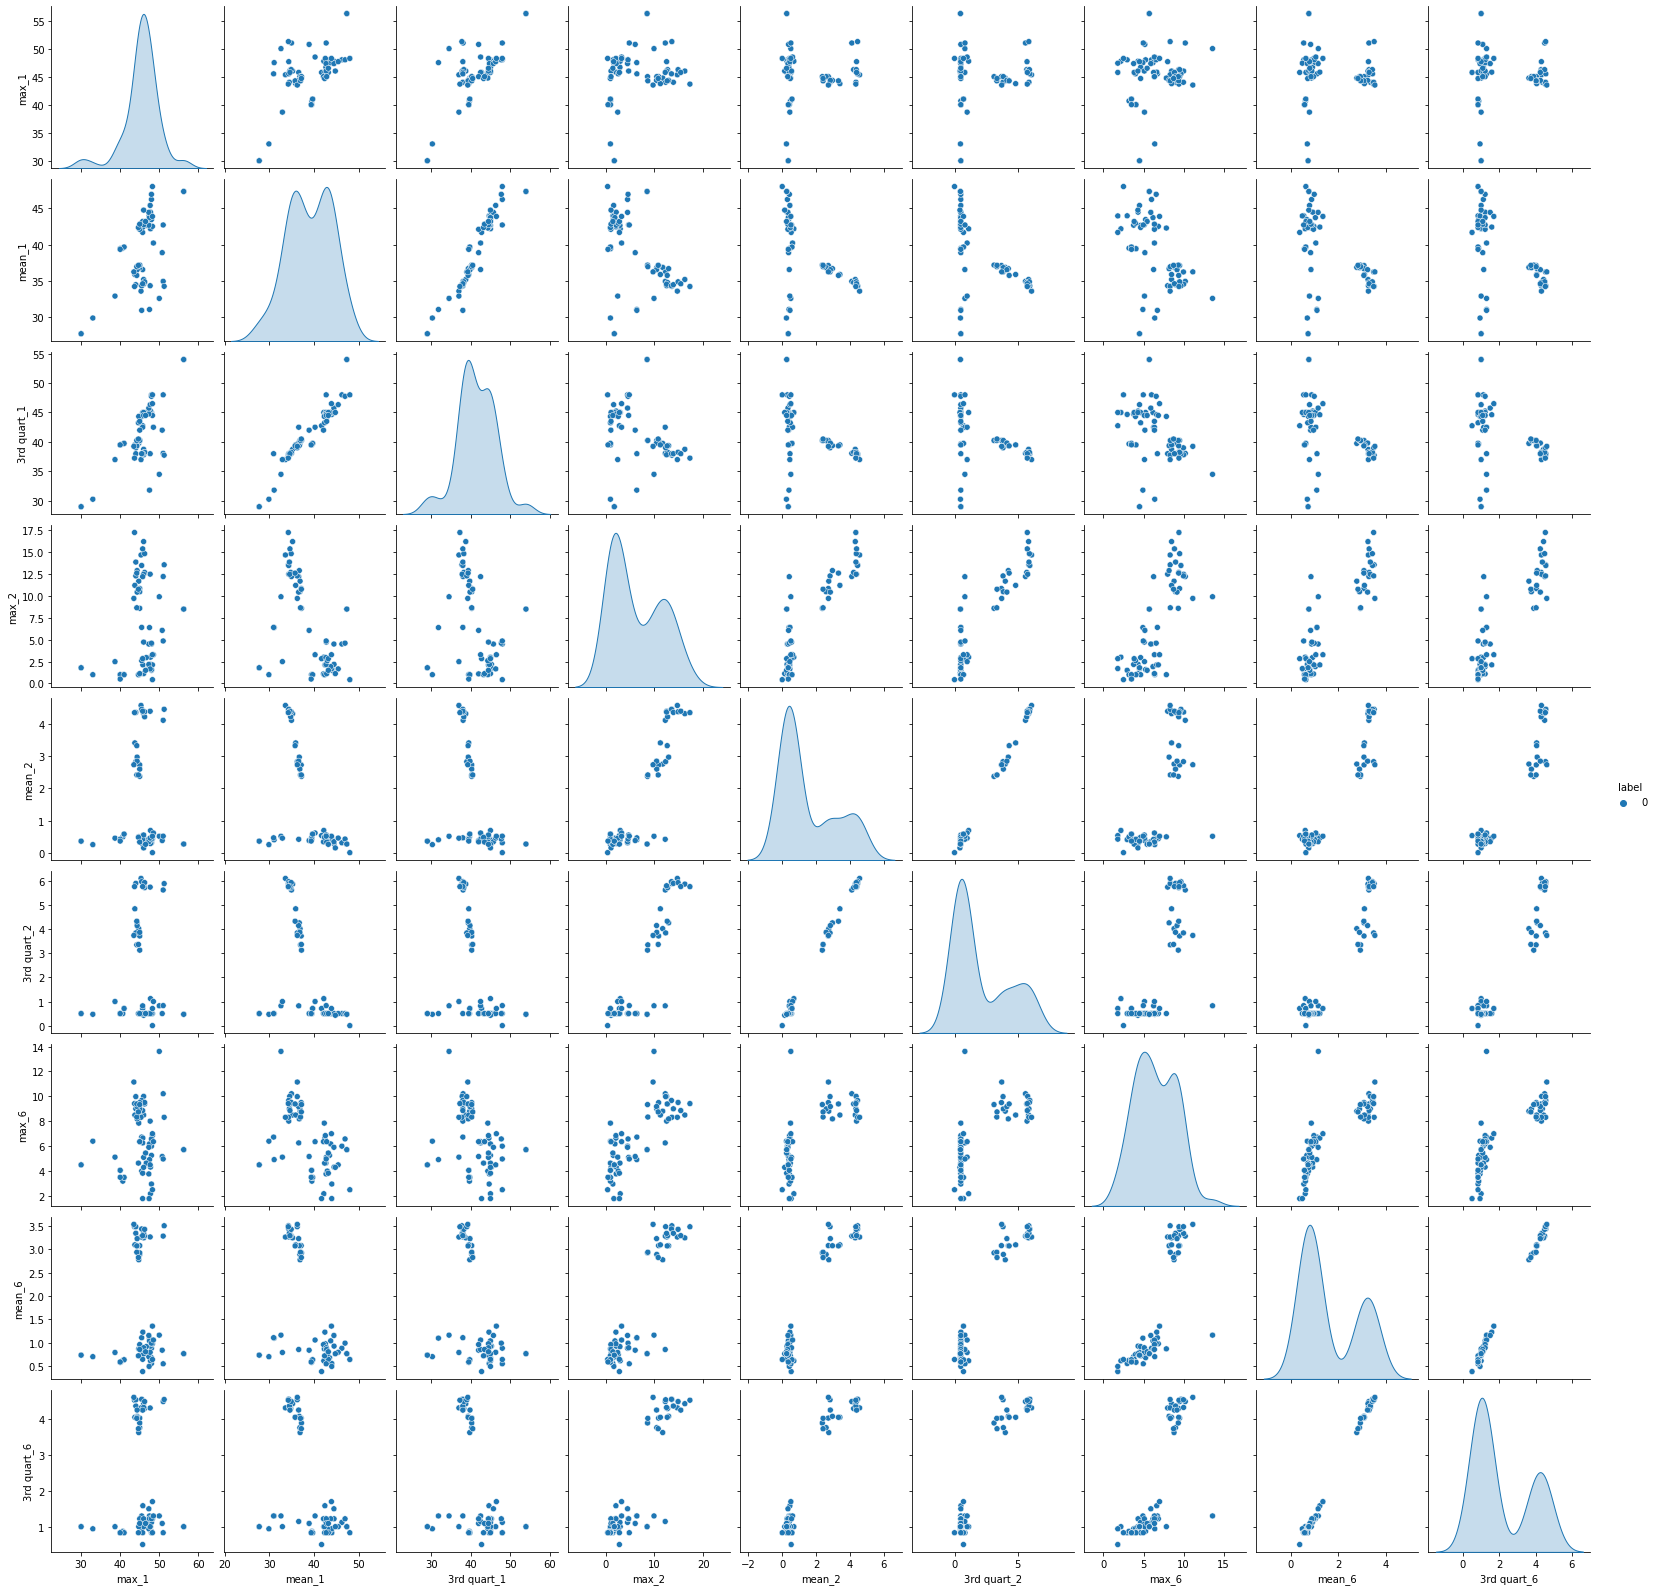

In [41]:
extr_columns = [feature + str("_") + str(i) for i in [1, 2, 6] for feature in ['max', 'mean', '3rd quart']]
extr_columns.append('label')
extr_train_dataset_new = train_dataset_new[extr_columns]

print()
print("\033[1mScatter plots of the features extracted from time series 1, 2, and 6 of each instance")
print()
print("\033[1m  Classes:")
print("  --------")
print("\033[1m  Bending: Class 1\n  Non-bending: Class 0")
print()
sns.pairplot(extr_train_dataset_new, hue='label')
plt.show()



#### ii. Splitted Plots
Break each time series in your training set into two (approximately) equal
length time series. Now instead of 6 time series for each of the training
instances, you have 12 time series for each training instance. Repeat the
experiment in 2(a)i, i.e depict scatter plots of the features extracted from both
parts of the time series 1,2, and 6. Do you see any considerable difference in
the results with those of 2(a)i?

In [42]:
time_series_statistical_features = ['min', 'max', 'mean', 'median', 'standard deviation', '1st quart', '3rd quart']
feature_names = [f"{param}_{i}" for i in range(1,13) for param in time_series_statistical_features]
train_dataset_new_split = pd.DataFrame(columns = feature_names)
ind_ = 1
instance_ind = []
label_names=[]
for file_ in train_files:
    instance_ind.append(ind_)
    label_names.append(file_.split("/")[3])
    if file_ == '../data/AReM/bending2/dataset4.csv':
        file = pd.read_csv(file_, skiprows = 5,usecols = [1, 2, 3, 4, 5, 6],names=['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'], delim_whitespace = True) 
    else:
        file = pd.read_csv(file_, skiprows = 4, usecols = [1, 2, 3, 4, 5, 6])  
        
    file = pd.concat([file[:int(len(file)/2)].reset_index(drop = True), file[int(len(file)/2):].reset_index(drop = True)], axis=1)

    stats = file.describe()

    data_row = []
    for i in range(1,len(list(file.columns))+1):
        data_row.extend([stats.loc['min'][i-1], stats.loc['max'][i-1], stats.loc['mean'][i-1], stats.loc['50%'][i-1], stats.loc['std'][i-1], stats.loc['25%'][i-1], stats.loc['75%'][i-1]])
    
    train_dataset_new_split = train_dataset_new_split.append(pd.DataFrame(np.array(data_row).reshape(1, 84), columns = feature_names)).reset_index(drop = True)
    train_dataset_new_split['label'] = label_names
    ind_ = ind_ + 1
    
train_dataset_new_split['label'] = (train_dataset_new_split['label'].isin(['bending1', 'bending2'])).astype(int)    
train_dataset_new_split.insert(loc = 0, column = 'Instance', value = instance_ind)

In [ ]:
extr_columns = [feature + str("_") + str(i) for i in [1, 2, 6, 7, 8, 12] for feature in ['max', 'mean', '3rd quart']]
extr_columns.append('label')
extr_train_dataset_new = train_dataset_new_split[extr_columns]

print()
print("\033[1mScatter plots of the features extracted from both parts of the time series 1,2, and 6 of each instance")
print()
print("\033[1m  Classes:")
print("  --------")
print("\033[1m  Bending: Class 1\n  Non-bending: Class 0")
print()

sns.pairplot(extr_train_dataset_new, hue='label')
plt.show()


Scatter plots of the features extracted from both parts of the time series 1,2, and 6 of each instance

  Classes:
  --------
  Bending: Class 1
  Non-bending: Class 0



<h3>Discussion</h3>
<br>

1. **Visual Analysis of Segments:**
   - The second plot facilitates the visual analysis of data segments, breaking the time series into equal-length halves.
   - While visually helpful, there's no substantial difference in the shapes observed in both plots.


2. **Data Distribution Similarity:**
   - Both plots exhibit similar data distributions, with no significant disparities between them.
   - This suggests that the division of the time series into halves does not greatly affect the overall data characteristics.


3. **Considerations for Time Series Transformation:**
   - There's a mention of potential issues with variable selection and the possibility of correlated predictors when transforming time series data.
   - The choice of whether to normalize the data is discussed, with the observation that normalization may not always improve model performance.

# 

#### Utility functions

In [44]:
def imbalance(dataset):
    print('Performing oversampling of dataset...')
    
    label_counts = dataset['label'].value_counts()
    major_label, minor_label = label_counts.idxmax(), label_counts.idxmin()
    major_count, minor_count = label_counts.max(), label_counts.min()
    
    minor_data = dataset[dataset['label'] == minor_label]
    major_data = dataset[dataset['label'] == major_label]
    
    oversampled_minor_data = resample(minor_data, replace=True, random_state=60, n_samples=major_count)
    
    dataset = pd.concat([major_data, oversampled_minor_data])
    
    return dataset


In [45]:
def dataset(files_data, orig_columns, l,desc_order_idx_,feature,binary=True):  
    ind_ = 1
    instances, instance_ind, label_names = [], [], []
    for file_ in files_data:
        instance_ind.append(ind_)
        label_names.append(file_.split("/")[3])
        if file_ == '../data/AReM/bending2/dataset4.csv':
            file = pd.read_csv(file_, skiprows = 5,usecols = [1, 2, 3, 4, 5, 6], names=['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'], delim_whitespace = True) 
        else:
            file = pd.read_csv(file_, skiprows = 4, usecols = [1, 2, 3, 4, 5, 6])  
        
        file.columns = orig_columns
        seg_length = int(file.shape[0] / l)
        segs_describe = []
        for i in range(l):
            cur_seg = file[i * seg_length : min((i + 1) * seg_length, file.shape[0])]
            
            cur_describe = cur_seg.describe().drop('count').T
            
            segs_describe.append(cur_describe.values.flatten())
        instances.append(np.concatenate(segs_describe, axis=None))
        

    feature_df = pd.DataFrame(instances, columns=desc_order_idx_)
    feature_df = feature_df.loc[:, feature]
   
    feature_df['label'] = label_names
    if binary:
        feature_df['label'] = (feature_df['label'].isin(['bending1', 'bending2'])).astype(int)      
    
    return pd.DataFrame(feature_df)

In [46]:
def rocplot(model, Y_train, Y_test, y_train_pred, y_test_pred):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.subplots_adjust(wspace=5)
    
    for i, c in enumerate(model.classes_):
        train_fpr, train_tpr,threshold = roc_curve(Y_train, y_train_pred[:, i], pos_label = c)
        test_fpr, test_tpr,threshold = roc_curve(Y_test, y_test_pred[:, i], pos_label = c)

        train_roc_auc = auc(train_fpr, train_tpr)
        test_roc_auc = auc(test_fpr, test_tpr)

        axes[0].plot(train_fpr, train_tpr, label="ROC Curve of {} : area = {} ".format(c, round(train_roc_auc)))
        axes[1].plot(test_fpr, test_tpr, label="ROC Curve of {} : area = {} ".format(c, round(test_roc_auc)))

    axes[0].plot([0, 1], [0, 1], linestyle='dotted')
    axes[0].set_xlabel("False Positive Rate (FPR)")
    axes[0].set_ylabel("True Positive Rate (TPR)")
    axes[0].set_title("ROC curves of Train set")
    axes[0].legend()
    
    axes[1].plot([0, 1], [0, 1], linestyle='dotted')
    axes[1].set_xlabel("False Positive Rate (FPR)")
    axes[1].set_ylabel("True Positive Rate (TPR)")
    axes[1].set_title("ROC curves of Test set")
    axes[1].legend()
    
    plt.tight_layout()  
    plt.show()

In [47]:
def train_logistic_regression(train_files, l, CV, penalty = "none", oversample = False):
    time_series_statistical_features = ['min', 'max', 'mean', 'median', 'standard deviation', '1st quart', '3rd quart']
    feature_names = [f"{param}_{i}" for i in range(1, 6*l_value+1) for param in time_series_statistical_features]
    ind_ = 1
    instances, instance_ind, label_names = [], [], []
    
    for file_ in train_files:
        instance_ind.append(ind_)
        label_names.append(file_.split("/")[3])
        if file_ == '../data/AReM/bending2/dataset4.csv':
            file = pd.read_csv(file_, skiprows = 5,usecols = [1, 2, 3, 4, 5, 6],names=['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'], delim_whitespace = True) 
        else:
            file = pd.read_csv(file_, skiprows = 4, usecols = [1, 2, 3, 4, 5, 6])  
    
        description = []
        for i in range(l):
            start1, end1 = i * int(file.shape[0] / l), min((i + 1) * int(file.shape[0] / l), file.shape[0])
            cur_seg = file[start1 : end1]
            cur_describe = cur_seg.describe().drop('count').T
            description.append(cur_describe.values.flatten())

        instances.append(np.concatenate(description))
    feature_df = pd.DataFrame(instances)
    feature_df.columns = feature_names
    feature_df = feature_df.loc[:, feature_names]
    feature_df['label'] = label_names
    feature_df['label'] = (feature_df['label'].isin(['bending1', 'bending2'])).astype(int)    

    train_set = pd.DataFrame(feature_df)
    if oversample:

        train_set = imbalance(train_set)


    trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]
    
    solver = {'l1': 'liblinear', 'l2': 'lbfgs'}.get(penalty, 'lbfgs')
    validator = StratifiedKFold(n_splits = CV, shuffle = True, random_state = 69)
    
    model = LogisticRegression(penalty = penalty, solver=solver)
    
    selector = RFECV(estimator = model, cv = validator, scoring = 'accuracy')
    selector.fit(trainX, trainY)
    
    p_value = selector.n_features_
    test_score = round(selector.cv_results_['mean_test_score'].max(), 4)
    train_error = round(1 - test_score, 4)

    return model, selector, p_value, test_score, train_error

In [48]:
def train_logistic_regression_2(model_name, train_files, l_value, binary_value, params, best):
    orig_columns = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
    describe_order = ['mean', 'std', 'min', '1st quart', 'median', '3rd quart','max']
    statistics = ['min','max','mean','median','std','1st quart', '3rd quart']

    desc_order_idx = [f"{param}_{i}" for i in range(1, 6*l_value+1) for param in describe_order]
    feature = [stat + "_"+str(i) for i in range(1, 6 * l_value + 1) for stat in statistics]
    train_set = dataset(train_files, orig_columns, l_value,desc_order_idx,feature,binary=binary_value)    
    test_set = dataset(test_files, orig_columns, l_value,desc_order_idx,feature,binary=binary_value)    

    trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]
    testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]
   
    model = model_name(**params)
    model.fit(trainX, trainY)
    
    train_score = round(model.score(trainX, trainY),4)
    test_score = round(model.score(testX, testY),4)
    
    if best:
        train_predictY_prob = model.predict_proba(trainX)
        predictY_prob = model.predict_proba(testX)

        predictY = model.predict(testX)
        conf_mat = confusion_matrix(testY, predictY)
        print("\033[1mConfusion Matrix:\n{}".format(conf_mat))
        
        rocplot(model, trainY, testY, train_predictY_prob, predictY_prob)

    return model, train_score, test_score

# 

#### iii. Time Series Segments
Break each time series in your training set into
l
∈ {
1
,
2
, . . . ,
20
}
time series
of approximately equal length and use logistic regression
to solve the binary
classification problem, using time-domain features. Remember that breaking
each of the time series does not change the number of instances. It only
changes the number of features for each instance. Calculate the p-values for
your logistic regression parameters in each model corresponding to each value
of
l
and refit a logistic regression model using your pruned set of features.
Alternatively, you can use backward selection using sklearn.feature
selection
or glm in R. Use 5-fold cross-validation to determine the best value of the pair
(
l, p
), where
p
is the number of features used in recursive feature elimination.
Explain what the right way and the wrong way are to perform cross-validation
in this problem.
Obviously, use the right way! Also, you may encounter the
problem of class imbalance, which may make some of your folds not having
any instances of the rare class. In such a case, you can use
stratifiedcross
validation.
Research what it means and use it if needed.

In [23]:
CV = 5

print("l value  ","      p value", "        test score", "    train error")
print("-----------------------------------------------------------------------")   

for l_value in range(1, 21):
    model, selector, p_value, test_score, train_error = train_logistic_regression(train_files, l_value, CV)
    print(l_value, p_value, test_score, train_error, sep="\t\t")

l value         p value         test score     train error
-----------------------------------------------------------------------
1		6		1.0		0.0
2		5		0.9429		0.0571
3		7		0.9857		0.0143
4		11		0.9571		0.0429
5		3		0.9857		0.0143
6		10		0.9714		0.0286
7		16		0.9714		0.0286
8		31		0.9714		0.0286
9		43		0.9857		0.0143
10		46		0.9714		0.0286
11		9		0.9857		0.0143
12		82		0.9857		0.0143
13		12		0.9857		0.0143
14		15		0.9714		0.0286
15		37		0.9857		0.0143
16		14		0.9857		0.0143
17		11		0.9857		0.0143
18		9		0.9857		0.0143
19		10		0.9857		0.0143
20		13		0.9857		0.0143


<h3>Discussion</h3>

Cross-validation should be done the right way, which means never showing the entire dataset to the model. The model should only be exposed to training data during training and cross-validation. If the model sees the test data before, it can underestimate the test error because it already encountered those data in some form of training. The key principle is to keep the test data hidden from the model throughout the cross-validation process to obtain accurate evaluation results.




#### iv. Confusion Matrix
Report the confusion matrix and show the ROC and AUC for your classifier
on train data. Report the parameters of your logistic regression
βi
’s as well
as the p-values associated with them.

In [24]:
l_value = 1
CV = 5

time_series_statistical_features = ['min', 'max', 'mean', 'median', 'standard deviation', '1st quart', '3rd quart']
feature_names = [f"{param}_{i}" for i in range(1, 7) for param in time_series_statistical_features]

classifier, selector, p_value, test_score, train_error = train_logistic_regression(train_files, l_value, CV)
selected_feature = [f for i, f in enumerate(feature_names) if selector.support_[i]]

print("\033[1mBest (l,p) pair:\n-----------------")
print(" l value: 1\n p value: 6\n Test score: 1.0\n")
print("Best selected features: ",selected_feature)

Best (l,p) pair:
-----------------
 l value: 1
 p value: 6
 Test score: 1.0

Best selected features:  ['min_1', '1st quart_1', '3rd quart_2', 'mean_5', 'median_5', '3rd quart_5']


In [25]:
trainX, trainY = train_dataset_summary_label.iloc[:, 1:-1], train_dataset_summary_label.iloc[:, -1]

trainX_const = sm.add_constant(trainX.loc[:, selected_feature].to_numpy(dtype = float))
model = sm.Logit(trainY.to_numpy(dtype = float), trainX_const)
logitres = model.fit(method='bfgs')
print(logitres.summary())

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       62
Method:                           MLE   Df Model:                            6
Date:                Tue, 17 Oct 2023   Pseudo R-squ.:                   1.000
Time:                        20:50:00   Log-Likelihood:            -4.7332e-05
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 9.588e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6448   1.73e+04     -

Confusion Matrix:
[[60  0]
 [ 0  9]]


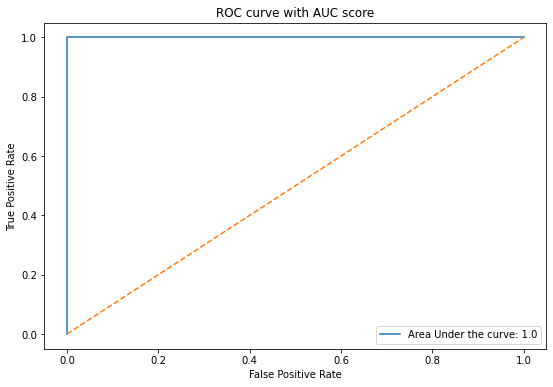

In [29]:
classifier.fit(trainX, trainY)

predicted_Y = classifier.predict(trainX)
predicted_Y_prob = classifier.predict_proba(trainX)

fpr, tpr, thresholds = roc_curve(trainY, predicted_Y_prob[:, 1])
roc_auc = auc(fpr, tpr)

cm = confusion_matrix(trainY, predicted_Y)

print("\033[1mConfusion Matrix:")
print(cm)

fig, axes = plt.subplots(figsize=(9, 6))
    
axes.plot(fpr, tpr, label=f"Area Under the curve: {round(roc_auc, 4)}")
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()
axes.set_title("ROC curve with AUC score")
plt.show()

#### v. Test Classifier
Test the classifier on the test set. Remember to break the time series in
your test set into the same number of time series into which you broke your
training set. Remember that the classifier has to be tested using the features
extracted from the test set. Compare the accuracy on the test set with the
cross-validation accuracy you obtained previously.

In [49]:
test_dataset_summary_label['label'] = (test_dataset_summary_label['label'].isin(['bending1', 'bending2'])).astype(int)    

In [50]:
testX, testY = test_dataset_summary_label.iloc[:, 1:-1], test_dataset_summary_label.iloc[:, -1]

testX_const = sm.add_constant(testX.loc[:, selected_feature].to_numpy(dtype = float))

predictY = classifier.predict(testX.loc[:, selected_feature])
predictY_prob = classifier.predict_proba(testX.loc[:, selected_feature])

fpr, tpr, thresholds = roc_curve(testY.to_numpy(dtype="int"), predictY_prob[:, 1], pos_label=1)

conf_mat = confusion_matrix(testY.to_numpy(dtype=float), predictY.round())
print("\033[1mConfusion Matrix:")
print(conf_mat)

fig, axes = plt.subplots(figsize=(9, 6))
roc_auc = auc(fpr, tpr)
    
axes.plot(fpr, tpr, label=f"Area Under the curve: {round(roc_auc, 4)}")

axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()
axes.set_title("ROC curve with AUC score")
plt.show()

ValueError: X has 6 features, but LogisticRegression is expecting 42 features as input.

<h3>Discussion</h3><br>
Comparing the accuracy on the test set with the cross-validation accuracy obtained previously we can conclude that the accuracy of both the training set and the test set is same (score = 1.0)

#### vi. Separation
Do your classes seem to be well-separated to cause instability in calculating
logistic regression parameters?<br><br>
<b>Answer:</b><br>
The common theme across these observations is the presence of complete separation in the data, indicated by both p-value analysis and software warnings. Complete separation leads to the unavailability of the Maximum Likelihood Estimator and results in parameter instability. The consensus is that the classes are well separated, causing this instability.

#### vii. Imbalance
From the confusion matrices you obtained, do you see imbalanced classes?
If yes, build a logistic regression model based on case-control sampling and
adjust its parameters. Report the confusion matrix, ROC, and AUC of the
model.

<b>We could see that the classes are imbalanced. We could use oversampling technique for resolving this.</b>

In [ ]:
orig_columns = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
describe_order = ['mean', 'std', 'min', '1st quart', 'median', '3rd quart','max']
desc_order_idx = [f"{param}_{i}" for i in range(1, 6*l_value+1) for param in describe_order]
feature = ['min_5', 'mean_5', '1st quart_1', '3rd quart_5']
train_set = dataset(train_files, orig_columns, 1,desc_order_idx,feature,True) 
train_set = imbalance(train_set)
test_set = dataset(test_files, orig_columns, 1,desc_order_idx,feature,True)    
trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]
testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]

In [ ]:
CV = 5

print("l value  ","      p value", "        test score", "    train error")
print("-----------------------------------------------------------------------")   

for l_value in range(1, 21):
    model, selector, p_value, test_score, train_error = train_logistic_regression(train_files, l_value, CV,oversample=True)
    print(l_value, p_value, test_score, train_error, sep="\t\t")

In [ ]:
l_value = 1
CV = 5

time_series_statistical_features = ['min', 'max', 'mean', 'median', 'standard deviation', '1st quart', '3rd quart']
feature_names = [f"{param}_{i}" for i in range(1, 6*l_value+1) for param in time_series_statistical_features]

classifier, selector, p_value, test_score, train_error = train_logistic_regression(train_files, l_value, CV,oversample=True)
selected_feature = [f for i, f in enumerate(feature_names) if selector.support_[i]]

print("\033[1mBest (l,p) pair:\n-----------------")
print(" l value: 1\n p value: 4\n Test score: 1.0\n")
print("Best selected features: ",selected_feature)

In [ ]:
classifier.fit(train_X, train_Y)

predicted_Y = classifier.predict(train_X)
predicted_Y_prob = classifier.predict_proba(train_X)

fpr, tpr, thresholds = roc_curve(train_Y, predicted_Y_prob[:, 1])
roc_auc = auc(fpr, tpr)

conf_matrix = confusion_matrix(train_Y, predicted_Y)

print("\033[1mConfusion Matrix:")
print(conf_matrix)

fig, axes = plt.subplots(figsize=(9, 6))
    
axes.plot(fpr, tpr, label=f"Area Under the curve: {round(roc_auc, 4)}")
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()
axes.set_title("ROC curve with AUC score")
plt.show()

In [ ]:
testX_const = sm.add_constant(testX.to_numpy(dtype = float))

predictY = classifier.predict(testX)
predictY_prob = classifier.predict_proba(testX)

fpr, tpr, thresholds = roc_curve(testY.to_numpy(dtype="int"), predictY_prob[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

conf_mat = confusion_matrix(testY.to_numpy(dtype=float), predictY.round())
print("\033[1mConfusion Matrix:")
print(conf_mat)

fig, axes = plt.subplots(figsize=(9, 6))
    
axes.plot(fpr, tpr, label=f"Area Under the curve: {round(roc_auc, 4)}")

axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()
axes.set_title("ROC curve with AUC score")
plt.show()

# 

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

In [ ]:
params = {
    'random_state': 69,
    'cv': 5,
    'scoring': 'accuracy',
    'penalty': 'l1',
    'solver': 'liblinear',
    'max_iter': 100
}


print("l value  ", "      train score", "    test score")
print("-----------------------------------------------------------------------")   

for l_value in range(1, 21):
    model, train_score, test_score  = train_logistic_regression_2(LogisticRegressionCV, train_files, l_value, True, params, False)
    print(l_value, train_score, test_score, sep="\t\t")

In [ ]:
params = {
        'solver' : 'liblinear',
        'max_iter' : 100,
        'penalty' : 'l1'

    }

model, train_score, test_score  = train_logistic_regression_2(LogisticRegression, train_files, 1, True, params, True)

#### ii. Comparison
Compare the
L1-penalized with variable selection using p-values. Which one
performs better? Which one is easier to implement?<br><br>
<b>Answer:</b> L1-penalized logistic regression outperforms variable selection based on p-values in terms of accuracy, both in cross-validation and on the test data. Notably, the L1-regularization approach is favored for its ease of implementation, as it eliminates the need for labor-intensive manual feature selection, which is a characteristic of the p-value-based method. The strong predictive performance of the L1-penalized model is reinforced by consistently high accuracy scores, particularly around 1.0

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments
Find the best l in the same way as you found it in 2(b)i to build an L1-penalized multinomial regression model to classify all activities in your training set. Report your test error. Research how confusion matrices and ROC
curves are defined for multiclass classification and show them for this problem if possible.

In [ ]:
params = {
    'random_state': 69,
    'cv': 5,
    'penalty': 'l1',
    'max_iter': 100,
    'multi_class': 'multinomial',
    'solver': 'saga'
}

print("l value  ", "      train score", "    test score")
print("-----------------------------------------------------------------------")   

for l_value in range(1, 21):
    model, train_score, test_score  = train_logistic_regression_2(LogisticRegressionCV, train_files, l_value, False, params, False)
    print(l_value, train_score, test_score, sep="\t\t")

<b>Best l value obtained: 2 </b><br>
<b>Test score: 0.9474</b>

In [ ]:
params = {
        'max_iter' : 100,
        'penalty' : 'l1', 
        'solver' : 'saga'
    }

model, train_score, test_score  = train_logistic_regression_2(LogisticRegression, train_files, 2, False, params, True)

#### ii. Naive Bayes

Repeat 2(c)i using a Naive Bayes’ classifier. Use both Gaussian and Multinomial priors and compare the results.

In [ ]:
params = {}

print("l value  ", "      train score", "    test score")
print("-----------------------------------------------------------------------")   

for l_value in range(1, 21):
    model, train_score, test_score  = train_logistic_regression_2(GaussianNB, train_files, l_value, False, params, False)
    print(l_value, train_score, test_score, sep="\t\t")

In [ ]:
params = {}

model, train_score, test_score  = train_logistic_regression_2(GaussianNB, train_files, 1, False, params, True)

In [ ]:
params = {}

print("l value  ", "      train score", "    test score")
print("-----------------------------------------------------------------------")   

for l_value in range(1, 21):
    model, train_score, test_score  = train_logistic_regression_2(MultinomialNB, train_files, l_value, False, params, False)
    print(l_value, train_score, test_score, sep="\t\t")

In [ ]:
params = {}

model, train_score, test_score  = train_logistic_regression_2(MultinomialNB, train_files, 1, False, params, True)

#### iii. Comparison
iii. Which method is better for multi-class classification in this problem?<br><br>
<b>Answer:</b> Logistic Regression consistently outperforms other classifiers, particularly Gaussian and Multinomial Naive Bayes, with higher AUC values indicating its superior classification performance. The test error rates are the same for all models, but Logistic Regression's stronger ROC curves make it the preferred choice. Additionally, Gaussian Naive Bayes excels in multi-class classification compared to Multinomial Naive Bayes. Lasso's performance closely matches that of Multinomial Naive Bayes. It's suggested that the performance differences may be influenced by the nature of time series data, which may exhibit variations post-median.

# 

## 3. ISLR 4.8.3

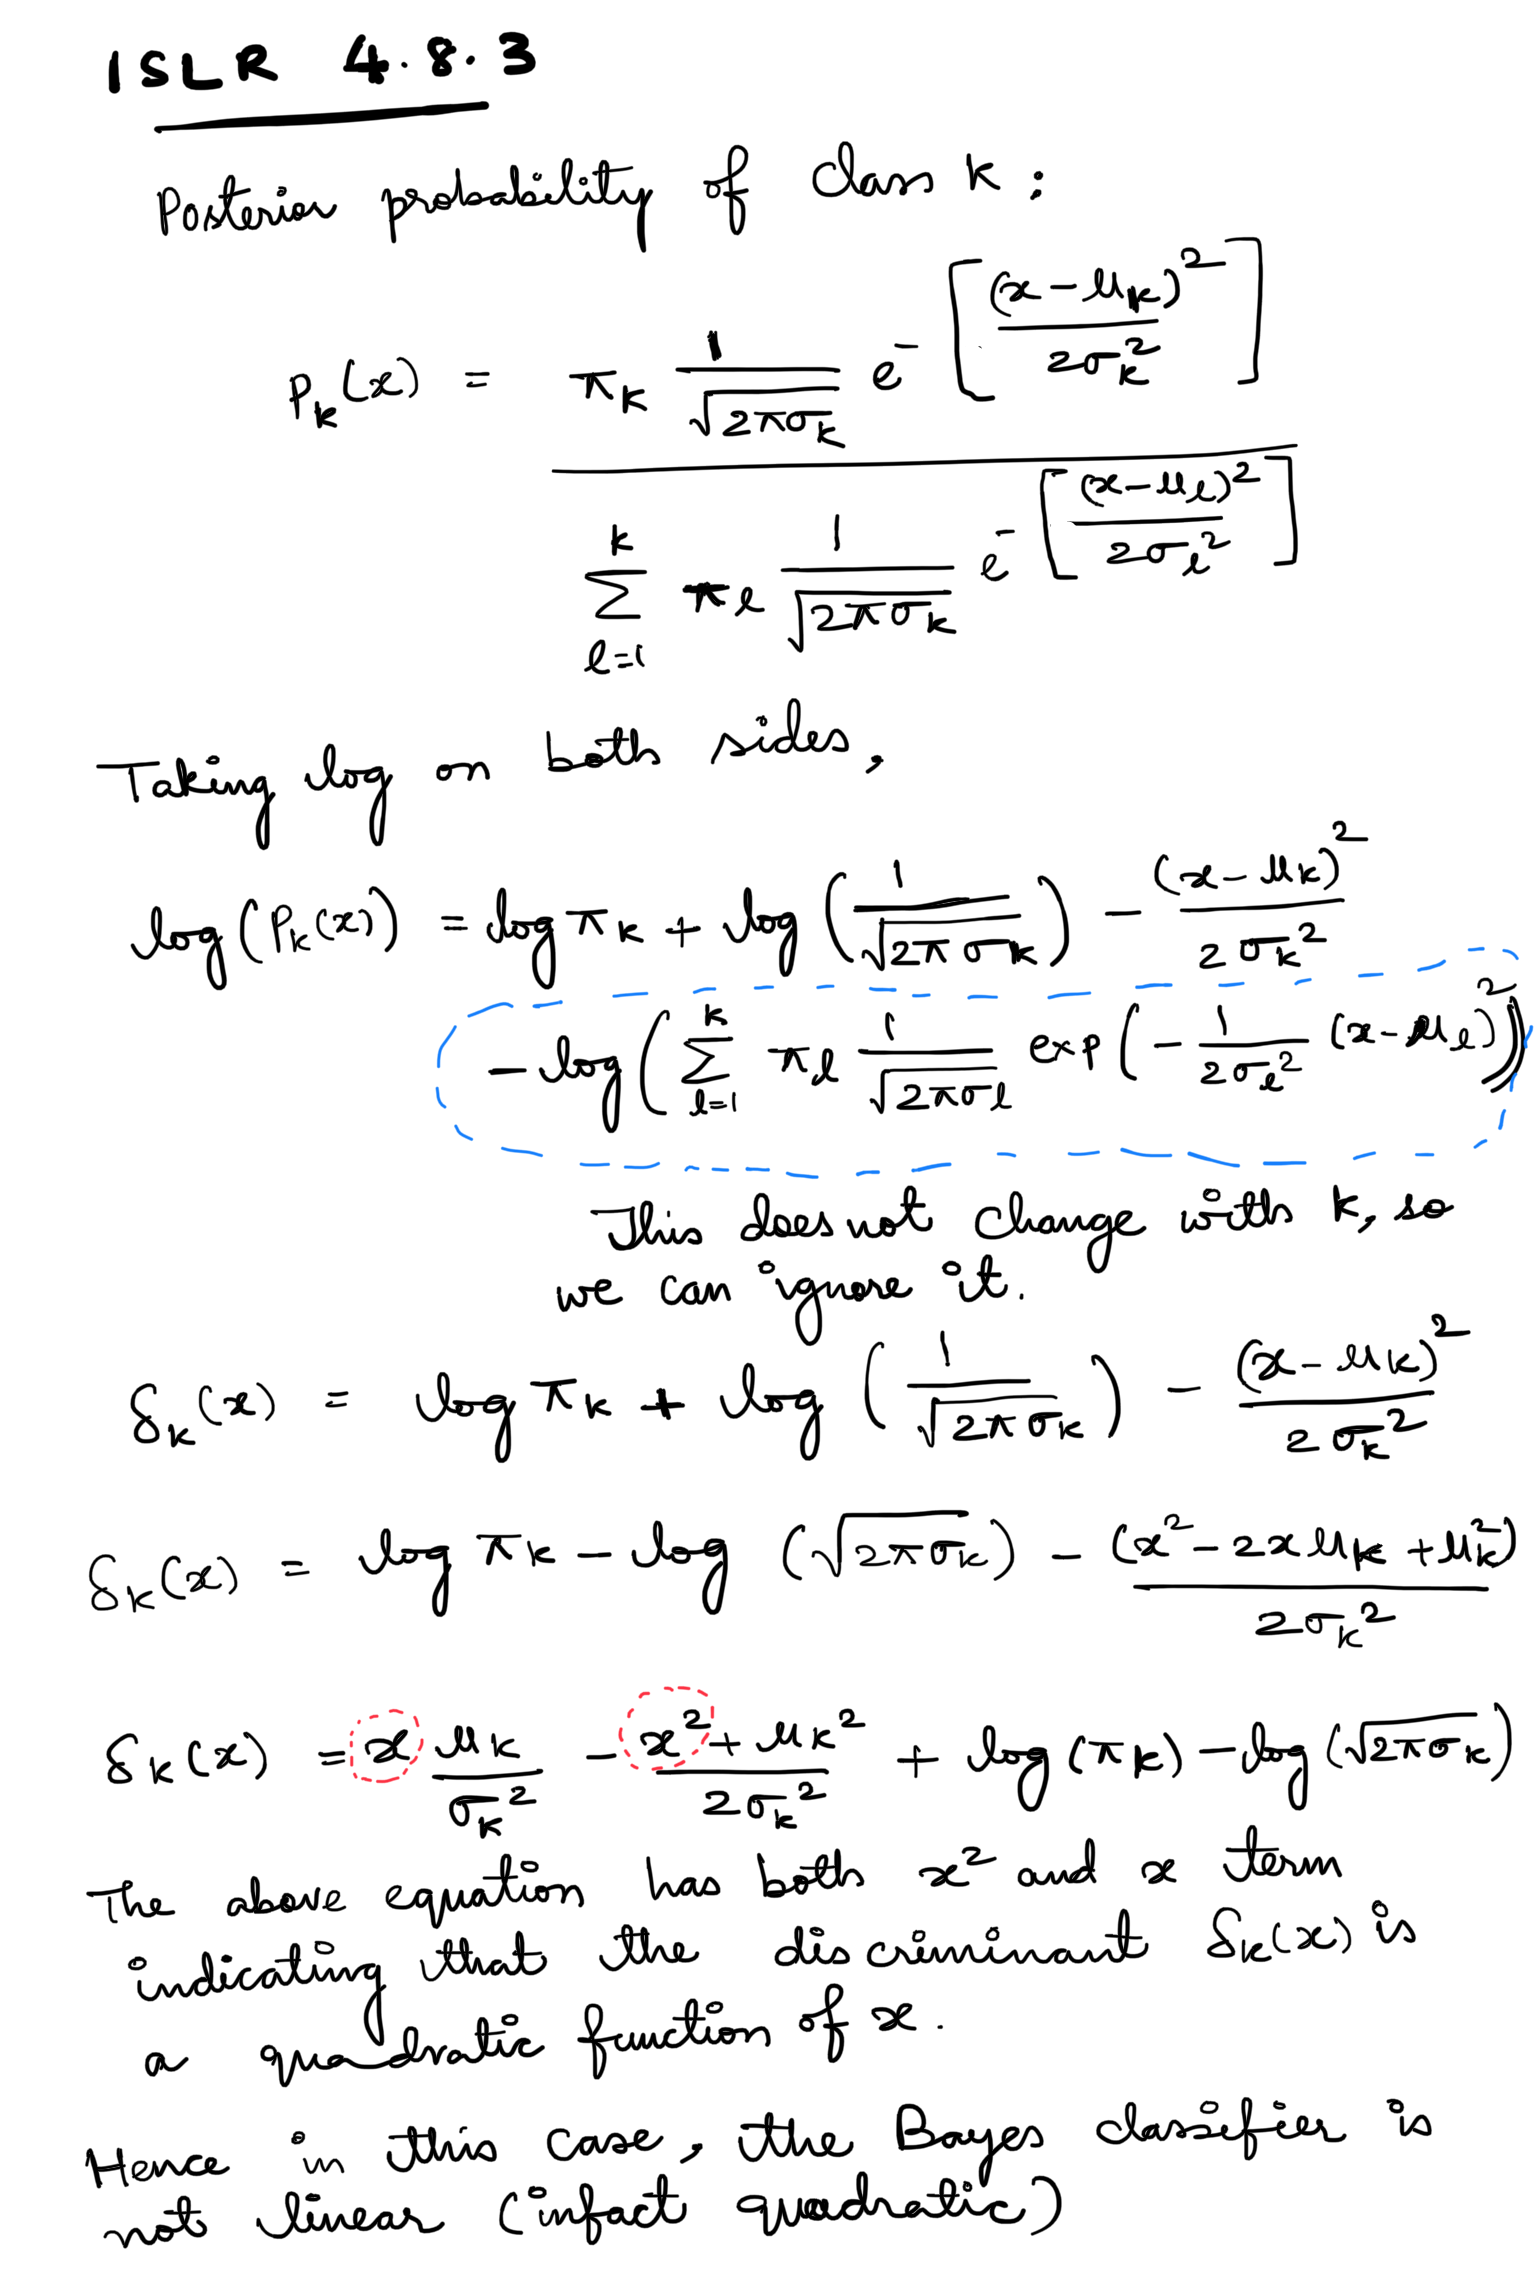

## 4. ISLR 4.8.7

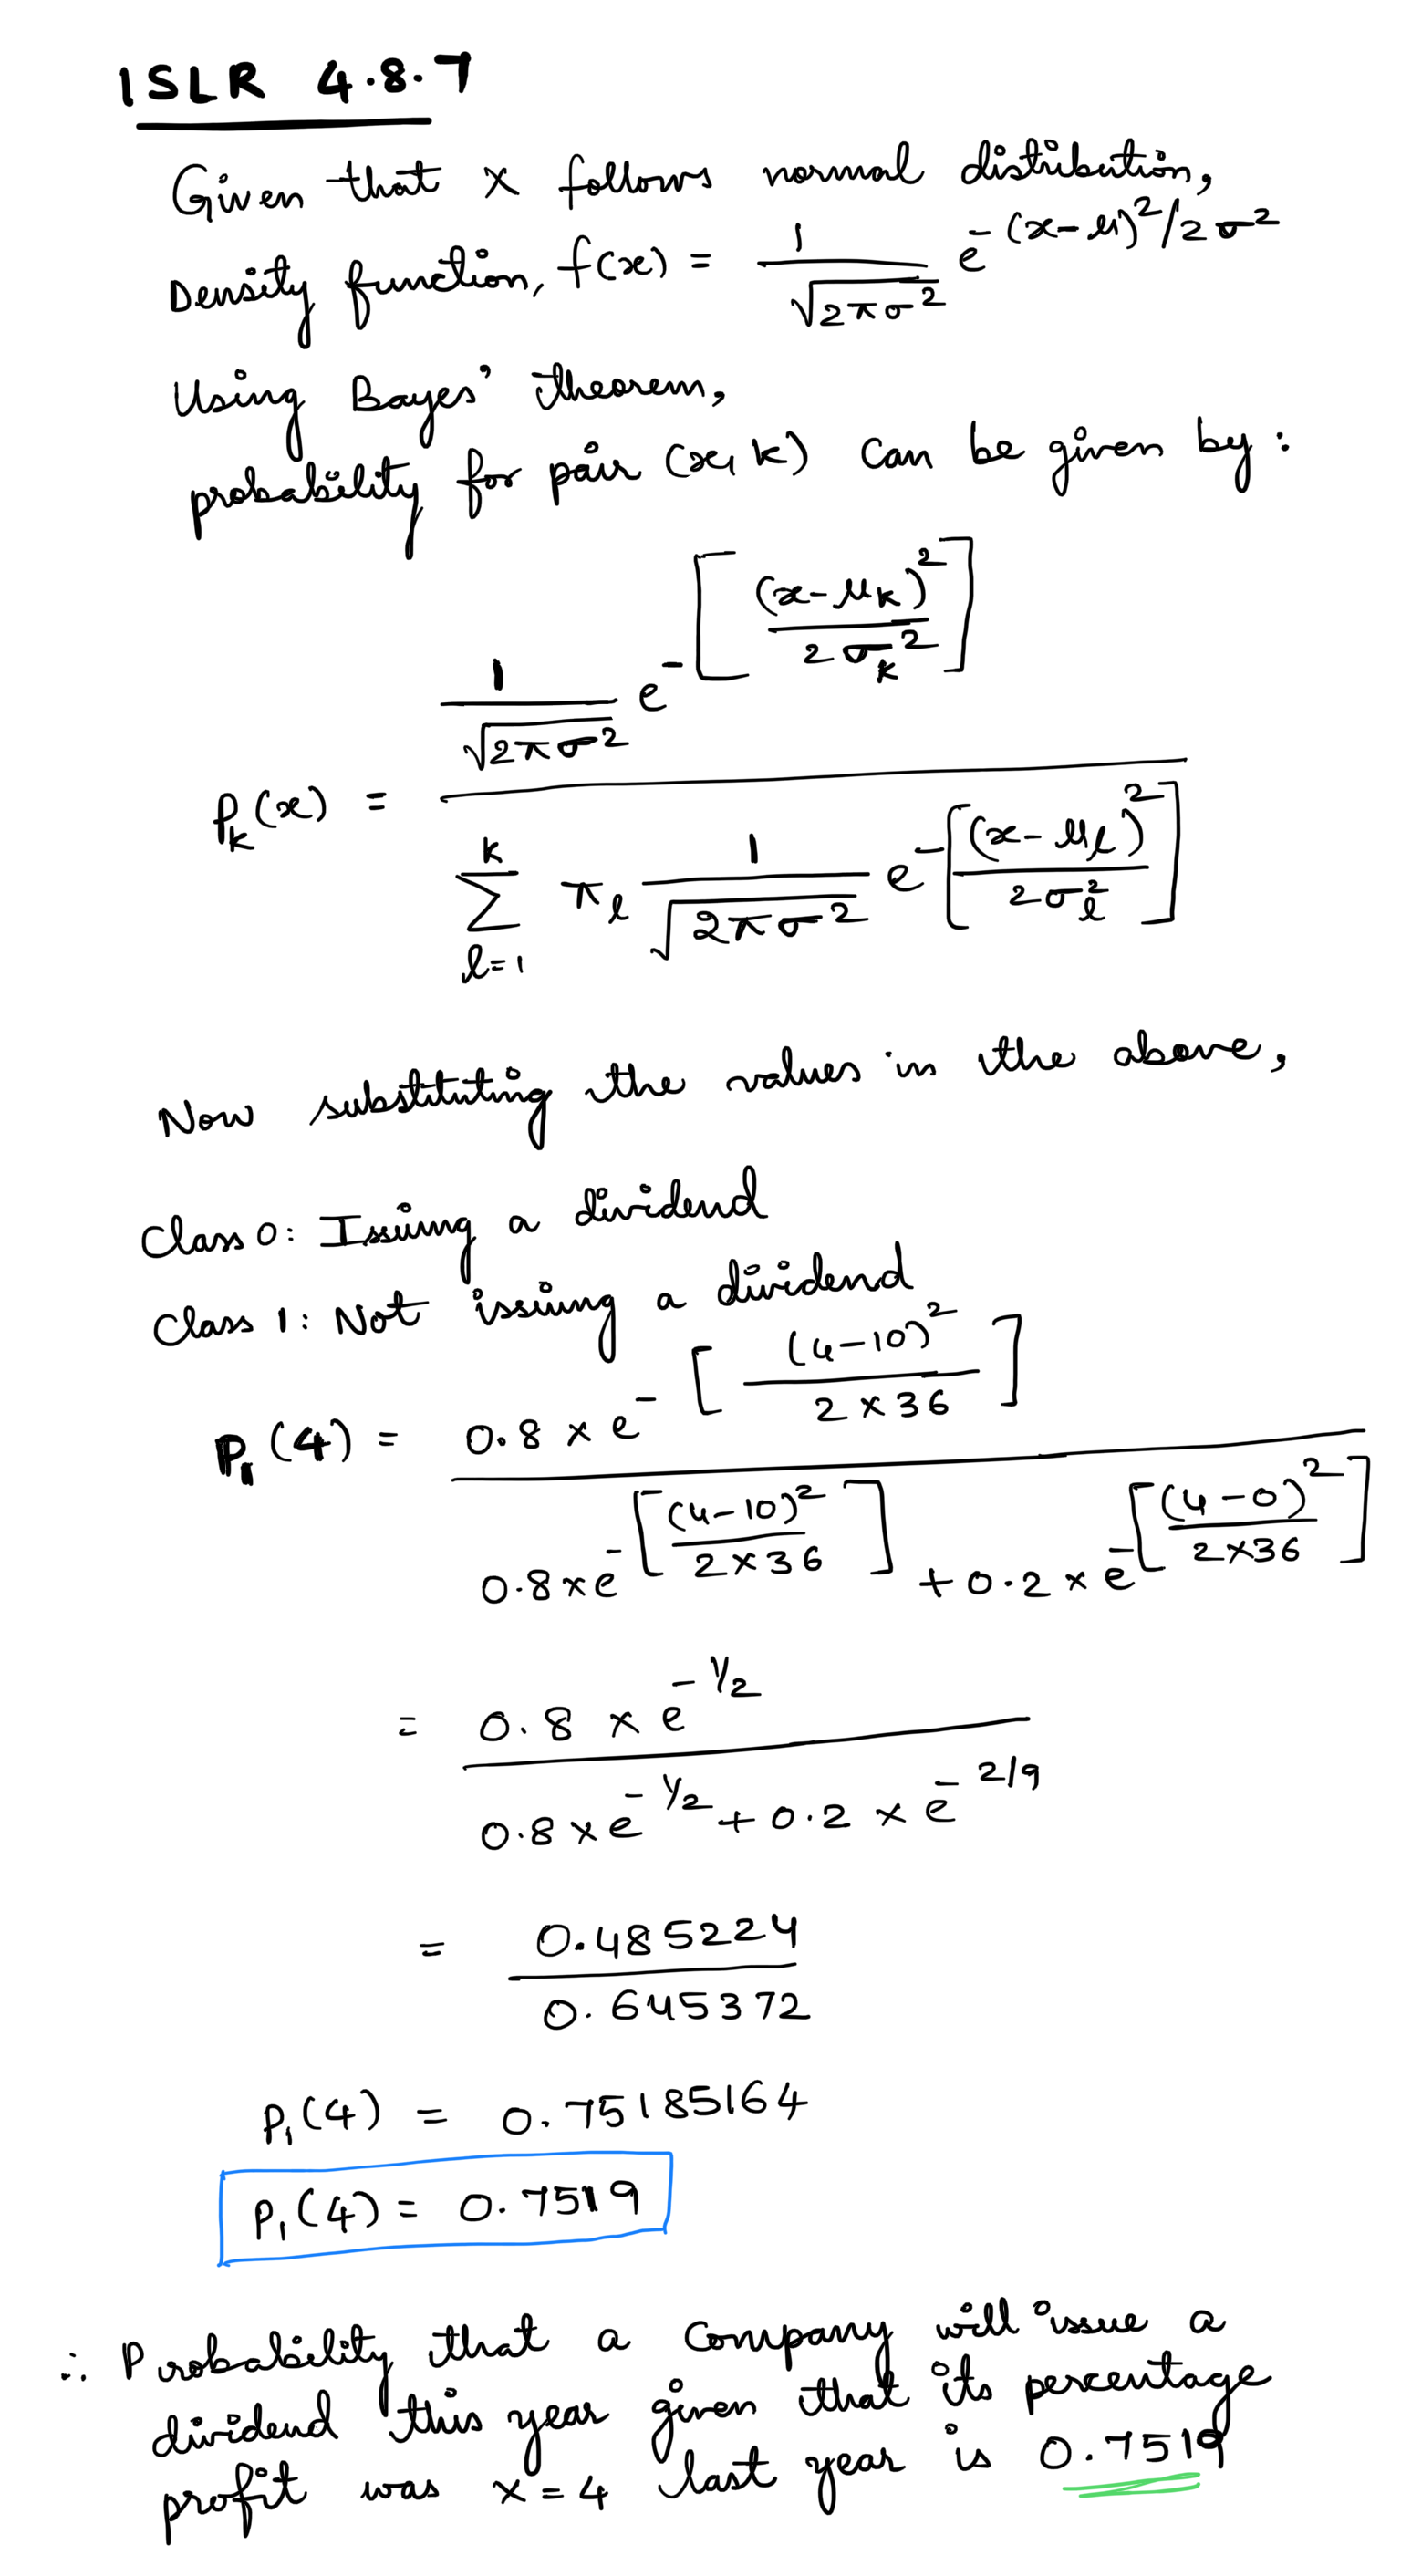

<center><b>Thank You</b></center>